In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

%matplotlib inline

# Load environment variables
load_dotenv()
DATABASE_URL = os.getenv("DATABASE_URL")
if not DATABASE_URL:
    raise ValueError("DATABASE_URL not found in .env file")

engine = create_engine(DATABASE_URL)

def get_engine():
    return engine

## Load and Prepare Data

In [2]:
def load_data():
    orders = pd.read_sql("SELECT * FROM orders WHERE is_active = TRUE", engine)
    order_items = pd.read_sql("SELECT * FROM order_items", engine)
    products = pd.read_sql("SELECT * FROM products WHERE is_active = TRUE", engine)
    users = pd.read_sql("SELECT * FROM users WHERE is_active = TRUE", engine)
    roles = pd.read_sql("SELECT * FROM roles", engine)
    return orders, order_items, products, users, roles

def prepare_dataset():
    orders, order_items, products, users, roles = load_data()
    df = (
        order_items
        .merge(orders, on="order_id", how="left")
        .merge(products, on="product_id", how="left")
        .merge(users, on="user_id", how="left")
        .merge(roles, on="role_id", how="left")
    )
    df["created_at"] = pd.to_datetime(df["created_at"])
    df["revenue"] = df["total_price"]
    return df

df = prepare_dataset()
print(f"Dataset prepared with {len(df)} rows.")
df.head()

Dataset prepared with 43 rows.


,order_item_id,order_id,product_id,quantity,total_price,user_id,status,total_amount,created_at_x,updated_at_x,...,full_name,email,password_hash,is_active,created_at,updated_at,deleted_at,deleted_by,role_name,revenue
0,1,5,1,3,120.0,1,pending,120.0,2025-12-12 00:31:17.487900,2025-12-12 00:31:17.487900,...,Daniela Updated,daniela.updated@example.com,"$bcrypt-sha256$v=2,t=2b,r=12$yLUU14JUAeEnuATrv...",True,2025-12-03 02:36:20.857959,2025-12-11 17:49:11.338294,None,None,admin,120.0
1,2,6,33,2,48.0,3,pending,48.0,2025-12-14 18:04:05.000585,2025-12-14 18:04:05.000585,...,Camila,camila@example.com,"$bcrypt-sha256$v=2,t=2b,r=12$xNG5rD08fhodO8IPu...",True,2025-12-04 15:56:56.675857,2025-12-04 19:05:23.793479,None,None,customer,48.0
2,3,7,33,3,72.0,3,pending,72.0,2025-12-14 18:04:18.304719,2025-12-14 18:04:18.304719,...,Camila,camila@example.com,"$bcrypt-sha256$v=2,t=2b,r=12$xNG5rD08fhodO8IPu...",True,2025-12-04 15:56:56.675857,2025-12-04 19:05:23.793479,None,None,customer,72.0
3,4,8,33,3,72.0,3,pending,72.0,2025-12-14 18:05:42.782772,2025-12-14 18:05:42.782772,...,Camila,camila@example.com,"$bcrypt-sha256$v=2,t=2b,r=12$xNG5rD08fhodO8IPu...",True,2025-12-04 15:56:56.675857,2025-12-04 19:05:23.793479,None,None,customer,72.0
4,5,9,33,2,48.0,3,pending,48.0,2025-12-14 18:07:37.921746,2025-12-14 18:07:37.921746,...,Camila,camila@example.com,"$bcrypt-sha256$v=2,t=2b,r=12$xNG5rD08fhodO8IPu...",True,2025-12-04 15:56:56.675857,2025-12-04 19:05:23.793479,None,None,customer,48.0


## Calculate Metrics

In [3]:
def calculate_metrics(df):
    metrics = {}
    metrics["average_ticket"] = df.groupby("order_id")["revenue"].sum().mean()
    metrics["sales_per_customer"] = df[df["role_name"] == "customer"].groupby("user_id")["revenue"].sum()
    metrics["sales_per_seller"] = df[df["role_name"] == "seller"].groupby("user_id")["revenue"].sum()
    metrics["top_products"] = df.groupby("name")["quantity"].sum().sort_values(ascending=False).head(5)
    return metrics

metrics = calculate_metrics(df)
print("Average Ticket:", metrics["average_ticket"])
print("Sales per Customer:")
print(metrics["sales_per_customer"])
print("Sales per Seller:")
print(metrics["sales_per_seller"])
print("Top 5 Products:")
print(metrics["top_products"])

Average Ticket: 6904.546511627907
Sales per Customer:
user_id
2     24408.0
3    272367.5
Name: revenue, dtype: float64
Sales per Seller:
Series([], Name: revenue, dtype: float64)
Top 5 Products:
name
Disco SSD 2TB        1003
Smartwatch            100
Laptop Core i5          2
Parlante Portátil       2
Name: quantity, dtype: int64


## Visualizations

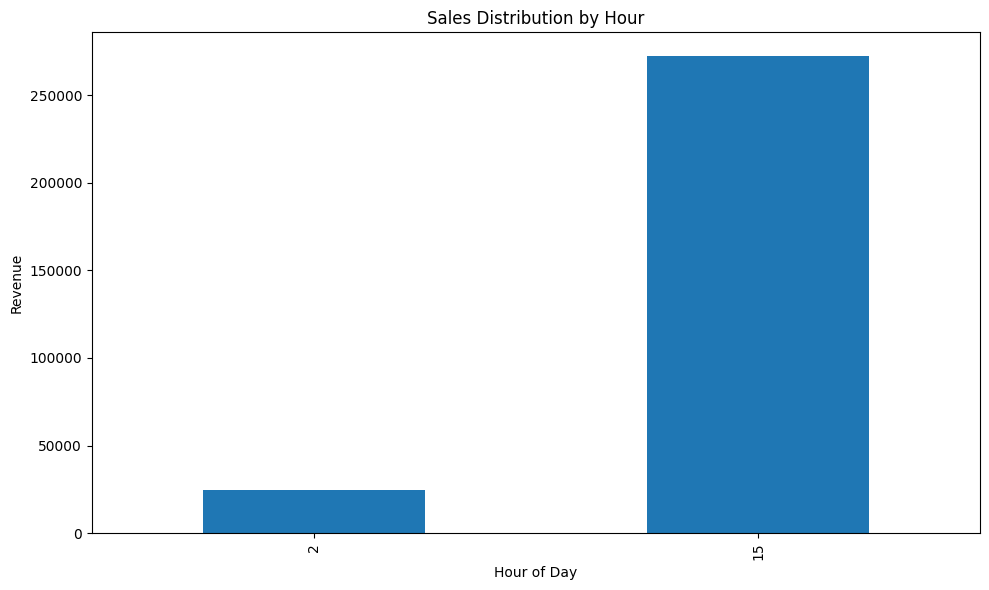

In [4]:
# Sales by hour
df["hour"] = df["created_at"].dt.hour
sales_by_hour = df.groupby("hour")["revenue"].sum()

plt.figure(figsize=(10, 6))
sales_by_hour.plot(kind="bar")
plt.title("Sales Distribution by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Revenue")
plt.tight_layout()
plt.savefig("../reports/sales_by_hour.png")
plt.show()

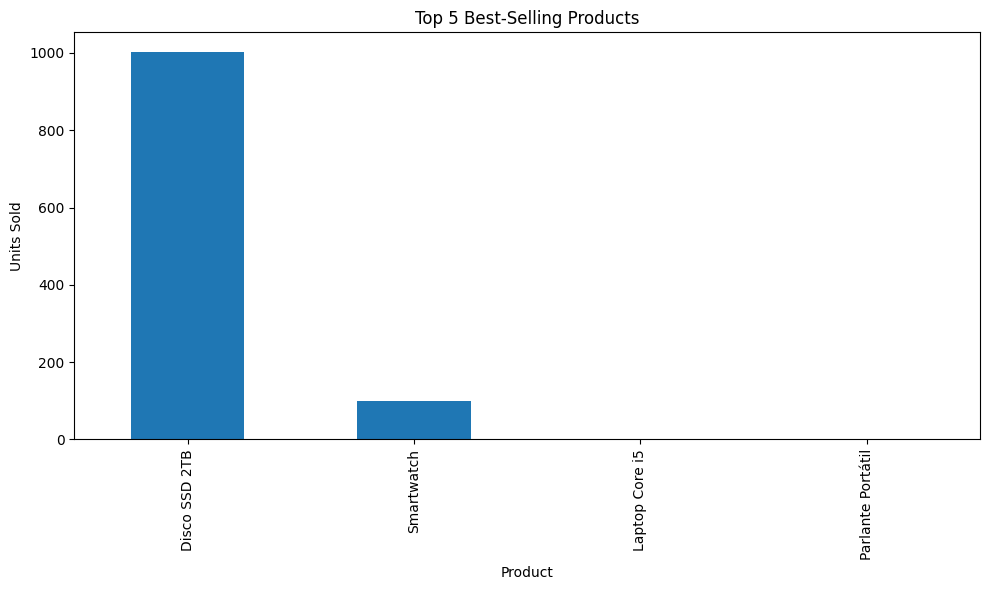

In [5]:
# Top 5 products
top_products = metrics["top_products"]

plt.figure(figsize=(10, 6))
top_products.plot(kind="bar")
plt.title("Top 5 Best-Selling Products")
plt.xlabel("Product")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.savefig("../reports/top_5_products.png")
plt.show()

## Save Metrics

In [6]:
metrics_df = pd.DataFrame({
    "Metric": ["Average Ticket"],
    "Value": [metrics["average_ticket"]]
})
metrics_df.to_csv("../reports/eda_metrics.csv", index=False)
print("Metrics saved to reports/eda_metrics.csv")

Metrics saved to reports/eda_metrics.csv
